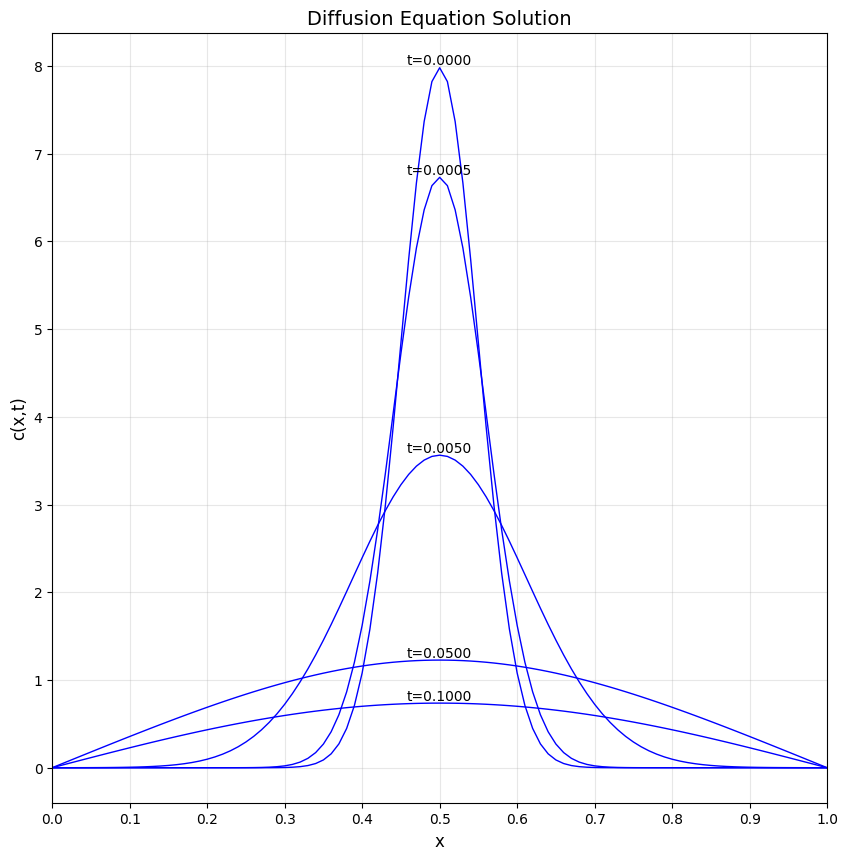

In [1]:
"""
扩散方程数值求解程序（一维显式差分格式）
采用有限差分法求解扩散方程 ∂c/∂t = α ∂²c/∂x²
边界条件：默认零梯度边界（Neumann边界条件）
初始条件：高斯分布浓度场
"""

# ==================== 导入依赖库 ====================
import numpy as np               # 数值计算库
import matplotlib.pyplot as plt  # 绘图库

# ==================== 参数设置 ======================
Nx = 100                         # 空间网格划分数量（注意实际节点数为Nx+1）
Nt = 2000                        # 时间步进总数
L = 1.0                          # 空间域长度（0 ≤ x ≤ L）
T = 0.1                          # 总模拟时间（0 ≤ t ≤ T）
dx = L / Nx                      # 空间步长
dt = T / Nt                      # 时间步长

mu = 0.5                         # 高斯分布均值（初始浓度中心位置）
sigma = 0.05                     # 高斯分布标准差（初始浓度扩散程度）

# ==================== 初始条件 ======================
def initial_condition(x):
    """
    定义初始浓度分布（高斯函数）
    参数：
        x : 空间坐标值
    返回：
        标准高斯分布值（面积归一化）
    """
    return np.exp(-((x - mu) ** 2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


# 初始化浓度场数组（时间维度在前，空间维度在后）
c = np.zeros((Nt + 1, Nx + 1))   # 创建(Nt+1)×(Nx+1)的二维数组

# 设置初始条件（t=0时的浓度分布）
for n in range(Nx - 1):
    c[0, n + 1] = initial_condition((n + 1) * dx)

# ==================== 数值求解 ======================
alpha = dt / dx**2               # 计算扩散系数组合参数（需满足α ≤ 0.5保证稳定性）

# 时间迭代（显式差分格式）
for i in range(Nt):
    # 空间遍历（注意边界处理：j=0和j=Nx保持初始零值）
    for j in range(1, Nx):
        # 有限差分公式：c^{n+1}_j = α*c^n_{j-1} + (1-2α)*c^n_j + α*c^n_{j+1}
        c[i + 1, j] = (
            alpha * c[i, j - 1] + (1 - 2 * alpha) * c[i, j] + alpha * c[i, j + 1]
        )

# ==================== 结果可视化 ====================
x = np.linspace(0, L, Nx + 1)    # 生成空间坐标数组
plt.figure(figsize=(10, 10))     # 创建画布

# 绘制指定时刻的浓度分布曲线
for i in [0, 10, 100, 1000, 2000]:
    plt.plot(x, c[i, :], "b-", linewidth=1)
    # 添加时间标签（显示在曲线中央上方）
    plt.text(0.5, c[i, 50], f"t={i * dt:.4f}", ha="center", va="bottom", fontsize=10)

# 设置图形属性
plt.title("Diffusion Equation Solution", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("c(x,t)", fontsize=12)
plt.xlim(0, L)                          # 固定x轴范围便于对比
plt.xticks(np.arange(0, L + 0.1, 0.1))  # 设置x轴刻度
plt.grid(alpha=0.3)                     # 添加半透明网格线

plt.show()


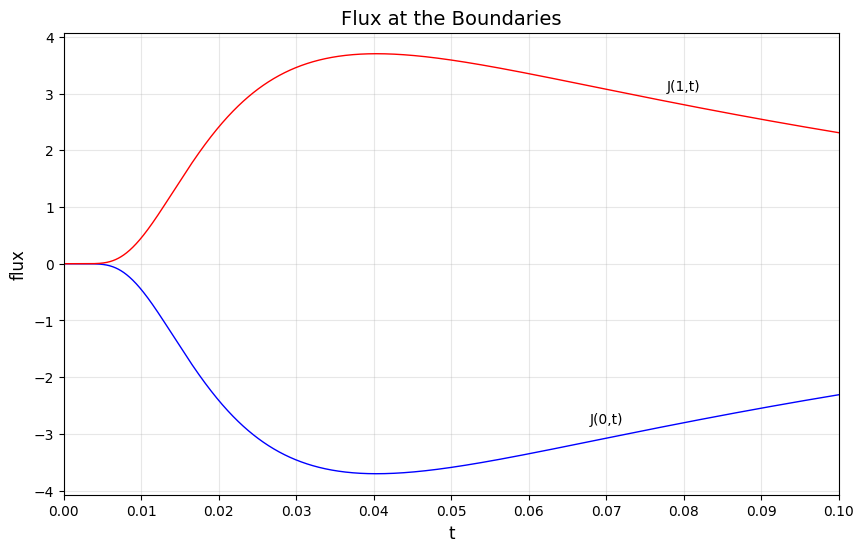

In [2]:
# ==================== 边界通量计算 ====================
# 创建通量数组（时间维度大小与浓度场时间维度一致）
J0 = np.zeros(Nt + 1)  # 左边界（x=0处）通量
J1 = np.zeros(Nt + 1)  # 右边界（x=L处）通量

# 遍历每个时间步计算边界通量
for i in range(Nt + 1):
    # 使用一阶差分近似计算边界通量（Fick定律）
    # 左边界通量公式：J(0,t) = -D*(c[0] - c[1])/dx （假设扩散系数D=1）
    J0[i] = (c[i, 0] - c[i, 1]) / dx

    # 右边界通量公式：J(L,t) = -D*(c[Nx-1] - c[Nx])/dx
    # 注意数组索引：Nx对应x=L的节点，Nx-1是倒数第二个节点
    J1[i] = (c[i, Nx - 1] - c[i, Nx]) / dx

# ==================== 通量可视化 ======================
# 生成时间坐标数组（用于x轴）
t = np.linspace(0, T, Nt + 1)

plt.figure(figsize=(10, 6))  # 创建新画布

# 绘制左边界通量曲线（蓝色实线）
plt.plot(t, J0, "b-", linewidth=1)
plt.text(0.07, J0[1400] + 0.2, "J(0,t)", ha="center", va="bottom", fontsize=10)

# 绘制右边界通量曲线（红色实线）
plt.plot(t, J1, "r-", linewidth=1)
plt.text(0.08, J1[1600] + 0.2, "J(1,t)", ha="center", va="bottom", fontsize=10)

# 设置坐标轴属性
plt.xlabel("t", fontsize=12)
plt.ylabel("flux", fontsize=12)
plt.xlim(0, T)
plt.xticks(np.arange(0, T + 0.01, 0.01))

# 添加标题和网格
plt.title("Flux at the Boundaries", fontsize=14)
plt.grid(alpha=0.3)

plt.show()

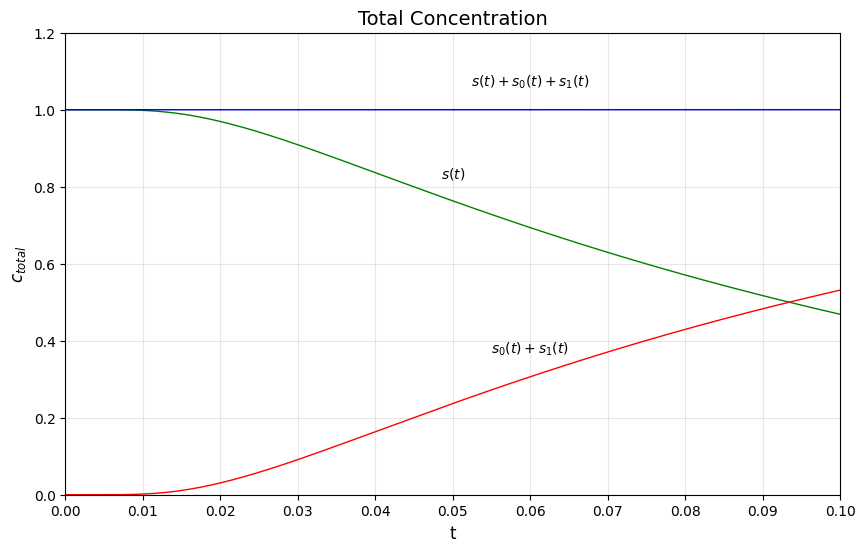

In [3]:
# ==================== 守恒量计算模块 ====================
# 初始化守恒相关量数组（时间维度与主程序一致）
s1 = np.zeros(Nt + 1)  # 右边界累积通量（x=L处流入量）
s0 = np.zeros(Nt + 1)  # 左边界累积通量（x=0处流出量）

# 使用梯形法则进行时间积分计算边界通量累积量
for i in range(Nt + 1):
    # 右边界累积量积分公式：∫J1 dt ≈ Δt*(0.5J1_0 + ΣJ1_1^{i-1} + 0.5J1_i)
    s1[i] = (np.sum(J1[:i]) + (J1[i] - J1[0]) / 2) * dt
    
    # 左边界累积量积分公式：注意符号处理（流出为负）
    s0[i] = (-(J0[i] - J0[0]) / 2 - np.sum(J0[:i])) * dt

# 初始化总浓度数组
s = np.zeros(Nt + 1)

# 使用辛普森法则进行空间积分计算系统内总浓度
for i in range(Nt + 1):
    """
    复合辛普森公式计算积分：
    ∫c(x,t)dx ≈ Δx/3*[c0 + cN + 2Σ偶数项c_j + 4Σ奇数项c_j]
    此处实现采用等间距网格的优化版本：
    s = (2*总和 + 2*奇数次项和 - 首项 - 末项) * dx/3
    """
    s[i] = (2 * np.sum(c[i, :]) + 2 * np.sum(c[i, :][1::2]) - c[i, 0] - c[i, Nx]) * dx / 3

# ==================== 守恒性验证可视化 ====================
plt.figure(figsize=(10, 6))

# 绘制三条守恒量曲线
plt.plot(t, s, "g-", linewidth=1)  # 系统内总浓度
plt.text(0.05, s[1000] + 0.05, "$s(t)$", ha="center", va="bottom", fontsize=10)

plt.plot(t, s0 + s1, "r-", linewidth=1)  # 边界通量累积量之和
plt.text(0.06, s0[1200] + s1[1200] + 0.05, "$s_0(t)+s_1(t)$", ha="center", va="bottom", fontsize=10)

plt.plot(t, s + s0 + s1, "b-", linewidth=1)  # 总守恒量
plt.text(0.06, s[1200] + s0[1200] + s1[1200] + 0.05, 
         "$s(t)+s_0(t)+s_1(t)$", ha="center", va="bottom", fontsize=10)

# 设置坐标轴属性
plt.xlabel("t", fontsize=12)
plt.ylabel("$c_{total}$", fontsize=12)
plt.xlim(0, T)
plt.xticks(np.arange(0, T + 0.01, 0.01))  # 精细时间刻度
plt.ylim(0.0, 1.2)
plt.title("Total Concentration", fontsize=14)
plt.grid(alpha=0.3)

plt.show()